In [179]:
from pythainlp import word_tokenize
from pythainlp.corpus import thai_stopwords
STOPWORDS = thai_stopwords()
from glob import glob
from tqdm import tqdm
from collections import Counter
import json, html, re
import numpy as np
import pandas as pd
from gensim.models import LdaModel
from gensim.corpora.dictionary import Dictionary
from datetime import timedelta, datetime
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
plt.style.use('ggplot')
font_path = '/Users/Nozomi/Library/Fonts/THSarabunNew.ttf'
fp = fm.FontProperties(fname=font_path)
    
def clean(text, hashtag=None):
    if hashtag != None:
        text = text.replace(hashtag, '')
    text = html.unescape(text)
    text = re.sub(r'http.+?(?:\\s|$)', '', text) # URL link
    text = re.sub(r'[“”„]', '"', text) # convert double quotations into "
    text = re.sub(r'[‘’′′′′`]', "'", text) # convert single quotations into '
    text = re.sub(r'[ \u00a0\xa0\u3000\u2002-\u200a\t\n#]+', ' ', text) # shrink whitespaces e.g. good  boy -> good boy
    text = re.sub(r'[\r\u200b\ufeff]+', '', text) # remove non-breaking space
    text = re.sub(r'ํา','ำ', text) # am
    text = re.sub(r'ำ([\u0e48\u0e49\u0e4a\u0e4b])', r'\1ำ', text) # am + tone -> tone + am, u0e48 = tone2
    return text.strip()

def tokenize(text, hashtag=None):
    tokens = word_tokenize(clean(text, hashtag), keep_whitespace='False')
    tokens = [token for token in tokens if token not in STOPWORDS and re.match(r'[ก-๙][ก-๙\\.\\-]+$', token)]
    return tokens

def get_hour(row, string=True):
    date = datetime(row.date.year, row.date.month, row.date.day, int(row.time[:2]))
    if string:
        return str(date)[:-3] # '2021-04-09 22:00'
    else:
        return date # datetime.datetime(2021, 4, 9, 22, 0)

def timerange(df):
    oldest = get_hour(df.iloc[len(df)-1], False)
    latest = get_hour(df.iloc[0], False)
    range_list = [str(oldest)]
    while range_list[-1] != str(latest):
        oldest = oldest + timedelta(hours=1)
        range_list.append(str(oldest))
    return pd.DataFrame(range_list, columns=['date'])

In [2]:
# List of filepath
jsons = glob('tweets/*.json')
for i, f in enumerate(jsons):
    print(i,f)

0 tweets/#กูสั่งให้มึงอยู่ใต้รัฐธรรมนูญ.json
1 tweets/test.json
2 tweets/#saveวันเฉลิม.json
3 tweets/#ธรรมศาสตร์และการชุมนุม.json
4 tweets/#เกียมอุดมไม่ก้มหัวให้เผด็จการ.json
5 tweets/#25พฤศจิกาไปSCB.json
6 tweets/#ม็อบ25พฤศจิกาทวงคืนสมบัติชาติ.json
7 tweets/#ม็อบ2ธันวา.json


In [61]:
### select data ###
i = 5
hashtag = jsons[i].split('/')[1].split('.json')[0] 
df = pd.read_json(jsons[i], lines=True)

### define duration ###
#df = df[(df.date >= '2020-11-24') & (df.date <= '2020-11-26')]

### tokenize ###
df['tokens'] = df.tweet.apply(lambda x: tokenize(x, hashtag))

### print data ###
print('tweets', len(df))
print('avg words', df.tokens.apply(len).mean().round(3))

tweets 49050
avg words 8.795


In [6]:
### save tokenized data ###
df.to_csv('tweets_tokenized/1_1.csv', index=False)

# associated words

In [20]:
### get most frequent hashtags ###
count = Counter()
for lst in df.hashtags:
    count.update(lst)
hashtags = {x[0]:Counter() for x in count.most_common(16)[1:]}

for i, row in df.iterrows():
    for hashtag in row['hashtags']:
        if hashtag in hashtags:
            hashtags[hashtag].update(row['tokens'])

In [25]:
for k, v in hashtags.items():
    print(k)
    for w, c in v.most_common(10):
        print(f"{w}({c})", end=',')
    print('\n')

อภิปรายไม่ใว้วางใจรัฐบาล
รัฐบาล(831),อภิปราย(824),ใว้(747),วางใจ(747),มข(107),พอกันที(106),เผด็จการ(105),คน(100),สลิ่ม(82),มศวขอ(77),

มขพอกันที
มข(258),พอกันที(253),อภิปราย(158),รัฐบาล(146),ใว้(118),วางใจ(118),เผด็จการ(117),จุดยืน(100),มศวขอ(99),สลิ่ม(89),

อภิปรายไม่ไว้วางใจรัฐบาล
อภิปราย(302),รัฐบาล(298),ไว้วางใจ(250),ใว้(50),วางใจ(50),ทำ(31),คน(28),ประชาชน(27),เผด็จการ(26),สลิ่ม(25),

มศวขอมีจุดยืน
มศวขอ(186),จุดยืน(186),อภิปราย(108),รัฐบาล(103),มข(97),พอกันที(97),ใว้(82),วางใจ(82),เผด็จการ(66),ซีน(56),

ที่ยุบอนาคตใหม่พี่มหาลัยกูทั้งนั้น
พี่(143),อนาคต(140),ยุบ(139),มหาลัย(138),เผด็จการ(36),สลิ่ม(36),ลูก(32),อภิปราย(26),รับใช้(26),รัฐบาล(25),

ธรรมนัส
ธรรม(136),นัส(127),อภิปราย(117),รัฐบาล(75),ใว้(69),วางใจ(69),ไว้วางใจ(46),เผด็จการ(37),ประยุทธ์(21),คน(21),

อภิปรายไม่ใว้วางใจ
อภิปราย(150),ใว้(135),วางใจ(135),เผด็จการ(59),รัฐบาล(47),ธรรม(26),นัส(26),ดำ(19),ไว้วางใจ(19),ประชาธิปไตย(19),

ศิลปากรขอมีซีน
ศิลปากร(109),ซีน(109),มข(64),พอกันที(63),มศวขอ(58),จุดยืน(55),อภิปราย(55),รัฐบาล

# LDA

In [67]:
%%time

num_topic = 5

corpus_dictionary = Dictionary(df.tokens)
corpus = []
for tokens_list in tqdm(df.tokens):
    corpus.append(corpus_dictionary.doc2bow(tokens_list))
lda = LdaModel(corpus, num_topics=num_topic, id2word=corpus_dictionary, passes=10)

100%|██████████| 49050/49050 [00:01<00:00, 47390.72it/s]


CPU times: user 3min 11s, sys: 1.15 s, total: 3min 12s
Wall time: 3min 13s


In [69]:
### print result of keywords ###

for i in range(10):
    print(f'|{i+1}', end='')
    for j in range(5):
        word, score = lda.show_topic(j)[i]
        print(f"|{word}|{score:.3f}",end="")
    print('|')

|1|คน|0.028|ตำรวจ|0.033|ค่า|0.015|นะคะ|0.060|ม็อบ|0.154|
|2|ประชาชน|0.028|อี|0.020|สลิ่ม|0.013|อย่า|0.035|พฤศจิกา|0.105|
|3|ทำ|0.021|คน|0.020|ข่าว|0.011|ใส่|0.015|ชุมนุม|0.025|
|4|ประเทศ|0.016|ทำ|0.017|ปั่น|0.009|ช่วยกัน|0.015|รัฐประหาร|0.024|
|5|กก|0.013|ทหาร|0.014|ถอนเงิน|0.009|คน|0.012|แกง|0.023|
|6|เค้า|0.011|ตู้|0.013|แท็ก|0.009|ขอให้|0.012|ต่อต้าน|0.020|
|7|ดี|0.009|เหี้ย|0.013|เท|0.009|พรุ่งนี้|0.012|รถติด|0.017|
|8|เก่ง|0.009|ขนาด|0.013|เปลี่ยนไป|0.009|รถ|0.012|ราษฎร|0.008|
|9|รัฐ|0.009|โดน|0.012|รัก|0.008|น้ำ|0.010|ประกาศ|0.008|
|10|รัฐบาล|0.009|หรอ|0.012|เนียน|0.008|เดิน|0.010|พฤศจิกายน|0.008|


In [71]:
### print distribution ###

for i in lda.get_document_topics(corpus[:10]):
    print(i)

[(0, 0.020014377), (1, 0.021266755), (2, 0.19692326), (3, 0.02001398), (4, 0.74178165)]
[(0, 0.35685754), (4, 0.620358)]
[(0, 0.07800621), (1, 0.05571648), (2, 0.09555941), (4, 0.76324445)]
[(0, 0.2), (1, 0.2), (2, 0.2), (3, 0.2), (4, 0.2)]
[(0, 0.2), (1, 0.2), (2, 0.2), (3, 0.2), (4, 0.2)]
[(0, 0.012932692), (1, 0.013016472), (2, 0.012942784), (3, 0.3773968), (4, 0.58371127)]
[(1, 0.034211487), (2, 0.06848257), (3, 0.23418112), (4, 0.6567834)]
[(1, 0.034211274), (2, 0.06848258), (3, 0.23418128), (4, 0.65678346)]
[(3, 0.25341743), (4, 0.72272396)]
[(0, 0.15983209), (1, 0.15770169), (2, 0.011181534), (3, 0.01154832), (4, 0.6597364)]


In [174]:
### prediction - argmax ###

n = len(df)

result_matrix = np.zeros((n, num_topic))
for row, dist in enumerate(lda.get_document_topics(corpus[:n])):
    for tpl in dist:
        col = tpl[0]
        result_matrix[row,col] = tpl[1]
        
result_df = pd.DataFrame(result_matrix)
result_df['topic'] = result_df.apply(lambda row: np.argmax(row), axis=1)
result_df['tweet'] = df.tweet[:n]
result_df['date'] = df.apply(lambda row: get_hour(row), axis=1)

result_df

In [126]:
### print prediction ###

print('|tweet|topic|prob of 1|2|3|4|5|\n|:-:|:-:|:-:|:-:|:-:|:-:|:-:|')
for i, row in result_df[['tweet','topic',0,1,2,3,4]].iterrows():
    if round(row[0],2) == 0.20:
        continue
    print(f'|{row.tweet}|{row.topic+1}|{row[0]:.3f}|{row[1]:.3f}|{row[2]:.3f}|{row[3]:.3f}|{row[4]:.3f}|')

Timestamp('2021-04-09 22:21:18+0700', tz='pytz.FixedOffset(420)')

<Figure size 1440x1080 with 0 Axes>

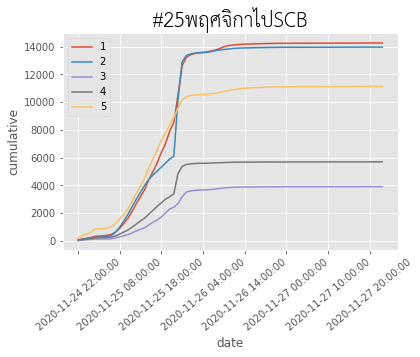

In [195]:
fig = plt.figure(figsize=(20,15))

tempdf = timerange(df[df.date < '2020-11-28'])
for t in range(5):
    tempdf[t+1] = tempdf.date.apply(lambda x: sum((result_df.date <= x) & (result_df.topic==t)))
    
tempdf.plot(x='date')
plt.title(hashtag, fontproperties=fp, fontsize=30)
plt.legend()
plt.ylabel('cumulative')
plt.xticks(rotation=40)
plt.show()

In [186]:
df[df.date < '2020-11-28']

,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,...,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest,tokens
80,1332367973059751937,1332367741601288192,2020-11-27 23:57:33+07:00,2020-11-27,23:57:33,700,14213571,phichai,phichai,,...,,,,,[],,,,,"[ป.ล., ส่งสาร, ดีใจ, รู้จัก, ดีใจ, เป็นเพื่อน,..."
81,1332346673029287937,1332346673029287936,2020-11-27 22:32:55+07:00,2020-11-27,22:32:55,700,1317360572522921986,pentodd1933,เป็นต็อด,,...,,,,,[],,,,,"[ชอบ, เอ, เนอ, จี้, ตามหา, หลักฐาน, น้องๆ, ตอน..."
82,1332339073659281409,1332339073659281408,2020-11-27 22:02:43+07:00,2020-11-27,22:02:43,700,3098117634,teeraplus,Pls.,,...,,,,,[],,,,,"[อี, มือ, ยิง, ทะเลาะ, น้อง, ยิง, เฟซ, เรื่อง,..."
83,1332335642492092417,1332335642492092416,2020-11-27 21:49:05+07:00,2020-11-27,21:49:05,700,1092024576,barbienista,🧡🍀𝒜𝓎𝓊𝓂𝒾 🍀🧡,,...,,,,,[],,,,,"[ทีม, ปั่น, ท่อ, น้ำเลี้ยง, พฤศจิกา, ห้า, แยก,..."
84,1332330979260731393,1332330979260731392,2020-11-27 21:30:33+07:00,2020-11-27,21:30:33,700,2283738841,jjjingji,ตะมุตะมิ อุอุอิอิ,,...,,,,,[],,,,,"[อย่า, ปั่น, แม็ก, พฤศจิกา, ห้า, แยก, ลาดพร้าว..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49045,1331257841672327170,1331257841672327168,2020-11-24 22:26:17+07:00,2020-11-24,22:26:17,700,1295445651472306176,commonpeoplex,CIIIP #ยกเลิก112,,...,,,,,[],,,,,[]
49046,1331257789386113025,1331257789386113024,2020-11-24 22:26:05+07:00,2020-11-24,22:26:05,700,948448013210431488,drgroupth,กลุ่มฟื้นฟูประชาธิปไตย | DRG,,...,,,,,[],,,,,"[ม็อบ, พฤศจิกา, เปลี่ยนไป, สำนักงานใหญ่, ลด, ก..."
49047,1331257775968505856,1331257775968505856,2020-11-24 22:26:02+07:00,2020-11-24,22:26:02,700,1230027384482603008,pxcyg,your moon,,...,,,,,[],,,,,[คับ]
49048,1331257700747862018,1331257700747862016,2020-11-24 22:25:44+07:00,2020-11-24,22:25:44,700,1296005753103212544,thammasatuftd,แนวร่วมธรรมศาสตร์และการชุมนุม,,...,,,,,[],,,,,"[ม็อบ, พฤศจิกา, เปลี่ยนไป, สำนักงานใหญ่, ลด, ก..."


# TF-IDF vectorization + SVD + K-means

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans

### prepare data : list of sentences (delimitered by space) -> TF-IDF vectorization
corpus = df.tokens.apply(lambda x: ' '.join(x))
vectorizer = TfidfVectorizer(max_features=20000, ngram_range=(1,2))
X = vectorizer.fit_transform(corpus)
print(X.shape)

### singular value decomposition & normalize
dim = 50

svd = TruncatedSVD(n_components=dim, n_iter=7, random_state=42)
X = svd.fit_transform(X)
normalized = [vec/np.linalg.norm(vec) if np.linalg.norm(vec) != 0 else np.zeros(dim) for vec in X ]

(49050, 20000)


In [15]:
### clustering 
num = 5

result = KMeans(n_clusters=num).fit_predict(normalized)

In [16]:
print("|tweet|topic|\n|:-:|:-:|")
for _ in range(30):
    i = np.random.randint(0, len(X))
    print(f"|{df.tweet[i]}|{result[i]+1}|")

|tweet|topic|
|:-:|:-:|
|ทุกคนใครไม่เกี่ยวรีบกลับบ้านเลยนะ เดี๋ยวพวกมันสร้างสถานะการณ์อีก #25พฤศจิกาไปSCB|4|
|ตร.จ่อหมายจับอาชีวะมือปืนป่วนม็อบ ยันยิงกันเอง-ปมเรื่องส่วนตัวไม่เกี่ยวชุมนุม  https://t.co/jG6TIc1t4T #25พฤศจิกาไปSCB #ทําในสิ่งที่ดีทําในสิ่งที่ถูก #ประชุมสภา #ม็อบ26พฤศจิกา #มือลั่นเหมือนพ่อมึงเลย #กูสั่งให้มึงอยู่ใต้รัฐธรรมนูญ #ส่งต่อคสอ #ตลาดนัดtreasure #ตํารวจไทยขยะสังคม|3|
|LIVE! การชุมนุมบริเวณอาคาร SCB รัชโยธิน #25พฤศจิกาไปSCB  https://t.co/SjnWPQQaQP ผ่าน @YouTube|3|
|ลุ้นให้ย้ายสถานที่อีกค่ะ แกงมันอีก สนุกดี #25พฤศจิกาไปSCB|4|
|CHILD IN MOB ในม็อบมีเด็ก #ม็อบ25พฤศจิกา #25พฤศจิกาไปSCB  https://t.co/X9RRwobovs|2|
|ตึกข้างบนก็มีทะเลดาวด้วยกัน5555555 พวกเราสู้ไปด้วยกันนะคะ #25พฤศจิกาไปSCB  https://t.co/vs33L00y3g|5|
|เสนอเล่นๆนะ ตอนนี้กำลังส่วนใหญ่อยู่ในกรุงเทพ ทั้งจนท ทั้งคนที่เกณฑ์ไป ถ้ามองเกมแล้วคือกะว่ายังไงต้องให้เกิดความรุนแรงแน่ๆ ถ้าวันนี้ยกเลิกม็อบ SCB กะทันหันก็ดีนะ แล้วเปลี่ยนเป็นม็อบตามเมืองใหญ่ต่างจังหวัด ประกาศซักตอน11โมงงี้ เราว่ามันอิมแพคเยอะอยู่นะ #25พฤศจ

In [55]:
a = "ซำ้"
b = "ซ้ำ"

a == b

False

In [56]:
clean(a) == clean(b)

True

In [57]:
clean(a)

'ซ้ำ'